# Gradient Boosting Machines

In [1]:
!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

## Problem Statement
To forcast sale for a store.
## Download Data

In [10]:
import os
import opendatasets as od
import pandas as pd
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [11]:
od.download('https://www.kaggle.com/c/rossmann-store-sales')

100%|██████████| 6.99M/6.99M [00:00<00:00, 15.8MB/s]


Extracting archive .\rossmann-store-sales/rossmann-store-sales.zip to .\rossmann-store-sales


In [12]:
os.listdir('rossmann-store-sales')

['sample_submission.csv', 'store.csv', 'test.csv', 'train.csv']

In [13]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

In [14]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [15]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [16]:
submission_df

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
41083,41084,0
41084,41085,0
41085,41086,0
41086,41087,0


In [17]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


store_df is supplemental information about the stores. Hence, merge store_df to train_df and test_df.

In [18]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [19]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [21]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

Do exploratory data analysis and visualization on the dataset:

In [20]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [ ]:
sns.violinplot(data=merged_df, x='DayOfWeek', y='Sales', title='Day of week v.s. Sales')

In [ ]:
px.histogram(merged_df[merged_df.Sales != 0], x='Sales', color='DayOfWeek', title='Day of week v.s. have Sales')

See that day of week with sales seems evenly distributed with 6 days (without 7)

In [ ]:
px.histogram(merged_df[merged_df.Sales == 0], x='DayOfWeek', title='Day of week v.s. not have Sales')

In [42]:
sun_df = merged_df[merged_df.DayOfWeek == 7]
print(f'On Sunday, have sales (>0) is '
      f'{round(sun_df[sun_df.Sales != 0].shape[0] / sun_df.shape[0] * 100, 2)} %')

On Sunday, have sales (>0) is 2.48 %


See on sunday, it is usually have no sales.

In [ ]:
px.scatter(merged_df.sample(2000),
           title='Date v.s. Sales',
           x='Date',
           y='Sales')

See that on paticular date may reasonable to predict sales (0 or high sales). However, in general it seems not highly correlated.

In [ ]:
px.scatter(merged_df, x='Sales', y='Customers', title='Customers v.s. Sales')

The plot shows that there seems have a relationship between Sales and Customers.

In [ ]:
sns.violinplot(data=merged_df, x='Open', y='DayOfWeek', title='Customers v.s. Sales')

See that Open is highly correlated with DayOfWeek.

In [ ]:
px.box(merged_df, x='Promo', y='Sales')

See that average sales will be higher if there is a promotion.

In [ ]:
px.box(merged_df, x='Promo2', y='Sales')

However, continuing promotion seems does not high related with Sales.

In [ ]:
sns.violinplot(data=merged_df, x='StateHoliday', y='Sales')

Seems holiday leads to low Sales:

In [62]:
holiday_df = merged_df[merged_df.StateHoliday != '0']
print(f'The proportion of store open on State Holiday: '
      f'{round(holiday_df[holiday_df.Open == 1].shape[0] / holiday_df.shape[0] * 100, 2)}%')

The proportion of store open on State Holiday: 2.93%


Hence, low Sales on State Holiday maybe is the reason that store not open that day.

In [ ]:
holiday_open_df = holiday_df[holiday_df.Open == 1]
sns.violinplot(data=holiday_open_df, x='StateHoliday', y='Sales')

Seems no huge difference between different holidays and non-holidays.

In [ ]:
sns.violinplot(data=merged_df, x='SchoolHoliday', y='Sales')

Seems no strong correlation between School Holiday and Sales.

In [ ]:
sns.violinplot(data=merged_df, x='StoreType', y='Sales')

Seems b type store are different to other three types.

<AxesSubplot:xlabel='Assortment', ylabel='Sales'>

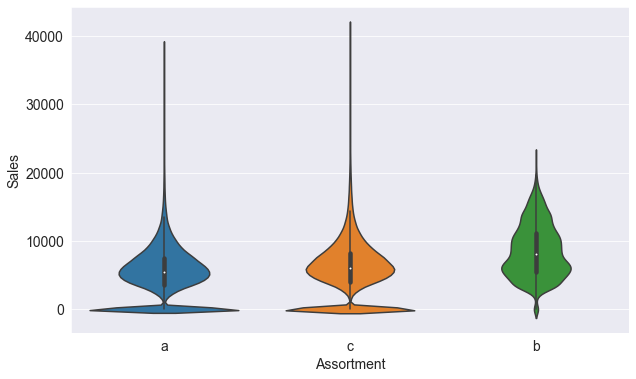

In [70]:
sns.violinplot(data=merged_df, x='Assortment', y='Sales')

b type is differnet to other 3.

In [73]:
print(f'correlation of competition distance and sales are: {merged_df.Sales.corr(merged_df.CompetitionDistance)}')

correlation of competition distance and sales are: -0.019229200503111124


See low negative correlation.
## Preprocessing and Feature Enginerring

In [74]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO